In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from tqdm import tqdm
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datetime import datetime
from torchvision import models
#from transformers import CLIPProcessor, CLIPModel
import os
import csv
from peft import LoraConfig, get_peft_model
import json

import pandas as pd
import os
import random
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json

import transformers
from transformers import CLIPProcessor, CLIPModel
from multilingual_clip import pt_multilingual_clip # Note: add device parameter to forward manually
import open_clip


from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")

FILE_SUBJECTMATTERS_PARSED = PARENT + os.getenv("FILE_SUBJECTMATTERS_PARSED")

DB_INPUT_ARTPIECES = PARENT + os.getenv("DB_INPUT_ARTPIECES")
DB_INPUT_ARTISTS = PARENT + os.getenv("DB_INPUT_ARTISTS")
FILE_SUBJECTMATTERS_PARSED = PARENT + os.getenv("FILE_SUBJECTMATTERS_PARSED")

MODELS_FOLDER = PARENT + os.getenv("MODELS_FOLDER")

In [20]:
model_name = "openai/clip-vit-large-patch14"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name).to(device)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
# Load the weights of the model
weights_path = os.path.join(MODELS_FOLDER, "art-base.pt")
# Load the weights of the model
model.load_state_dict(torch.load(weights_path, map_location=device))

C:\Users\victo\AppData\Local\Temp\ipykernel_21904\1118417068.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=

<All keys matched successfully>

In [101]:
model_name_db = "art-base"
path_embeddings = PARENT + os.getenv(f"{model_name_db}_path_embeddings")
path_index_to_recordID = PARENT + os.getenv(f"{model_name_db}_path_index_to_recordID")
Embeddings = np.load(path_embeddings)
Embeddings.shape

(5301, 768)

In [75]:
# Get the artworks data
ARTWORKS = pd.read_csv(DB_INPUT_ARTPIECES)
# Sort ARTWORKS by the recordID 
ARTWORKS = ARTWORKS.sort_values(by=['recordID'])
ARTWORKS.head(1)

,recordID,workID,creatorID,language,title,objectWorkType,termClassification,materials,signatureFullDescription,creationFullDescription,...,physicalAppearanceDescription,imageType,imageColor,imageLowResFilename,imageHighResFilename,imageCopyright,formalDescriptionTermStylesPeriods,height,width,ratio
0,64,8181,Auth:509:309,fre,La Crucifixion,détrempe,peinture (Dept. Art Ancien),toile|tempera,NaN,1460.0,...,Tempera sur toile,digitale JPG,photo couleurs,/art-foto/old/internet/Bouts-8181dig-L.jpg,/art-foto/old/intranet/Bouts-8181dig-H.jpg,NaN,Primitifs flamands,181.5,153.5,0.84573


In [ ]:
# Methods to get an image from a recordID
def fixPath(path):
    return path.replace(".././", "../")

recordID_to_imageLowResFilename = {}
for index, row in ARTWORKS.iterrows():
    recordID = row["recordID"]
    path = row["imageLowResFilename"]

    # Fix the imageLowResFilename
    path = fixPath(IMAGES_FOLDER + path[1:])

    path = path.replace("internet", "Internet")
    path = path.replace("Mod", "mod")
    path = path.replace("MOD", "mod")
    path = path.replace("Old", "old")
    path = path.replace("Stefaan", "stefaan")
    path = path.replace("Art-Foto", "art-foto")
    path = path.replace("\\", "/")

    recordID_to_imageLowResFilename[recordID] = path

# Test it
for recordID, path in recordID_to_imageLowResFilename.items():
    if not os.path.exists(path):
        print(f"Path does not exist: {path}")

In [23]:
# Get the artworks data
ARTISTS = pd.read_csv(DB_INPUT_ARTISTS)
ARTISTS.head(1)

,creatorID,creatorLastName,creatorFirstName,creatorBirthAndDeathDescription,creatorNationality,creatorDeathDate,creatorBirthDate
0,Auth:509:309,Bouts,Dirk,Haarlem (Pays-Bas) vers 1410 ? - Louvain 1475,NaN,1475.0,1410.0


In [111]:
index_to_recordID = json.load(open(path_index_to_recordID, "r"))

In [103]:
recordID_to_index = {}
for i, recordID in enumerate(ARTWORKS["recordID"]):
    recordID_to_index[recordID] = i

In [ ]:
subjectmatter_json = json.loads(open(FILE_SUBJECTMATTERS_PARSED, "r", encoding="utf-8").read())

# dict_keys()
def get_structured_flattened(recordID):

    index = recordID_to_index[recordID]

    proper_nouns = set()
    for key in ['subjectMatterSubjectTerms', 'subjectMatterIconographicTerms', 'subjectMatterConceptualTerms']:
        terms = subjectmatter_json[index]["structured"][key]["flattened"]
        proper_nouns.update(terms)

    return proper_nouns

In [105]:
terms_per_recordID = {}
for recordID in tqdm(ARTWORKS["recordID"]):
    terms_per_recordID[recordID] = get_structured_flattened(recordID)

# Create a DataFrame from the dictionary
terms_df = pd.DataFrame(columns=["recordID", "terms"])
terms_df["recordID"] = terms_per_recordID.keys()
terms_df["terms"] = terms_per_recordID.values()
# Keep only the rows with proper nouns
terms_df = terms_df[terms_df["terms"].str.len() > 0]
terms_df.reset_index(drop=True, inplace=True)
terms_df

100%|██████████| 5301/5301 [00:00<00:00, 311916.13it/s]


,recordID,terms
0,64,"{Crucifixion, chapeau, épée, eau, enfant, robe..."
1,77,"{table, arbre, femme, chaise, figure}"
2,78,"{de face, enfant, robe, portrait, noeud, Louis..."
3,79,"{souche de cheminée, miroir, bourgeoisie, musi..."
4,80,"{paysage, être imaginaire, sceptre, homme, jeu..."
...,...,...
3637,11594,"{de trois-quarts, barbe, être imaginaire, port..."
3638,11638,"{chapeau, tableau, homme, parasol, arbre, port..."
3639,11645,"{robe, en buste, coiffe, femme, vêtement, figure}"
3640,11646,"{en buste, homme, figure, habit}"


In [106]:
cosine_similarity_matrix = cosine_similarity(Embeddings)
cosine_distance_matrix = 1 - cosine_similarity_matrix

Terms: ['table', 'arbre', 'femme', 'chaise', 'figure']


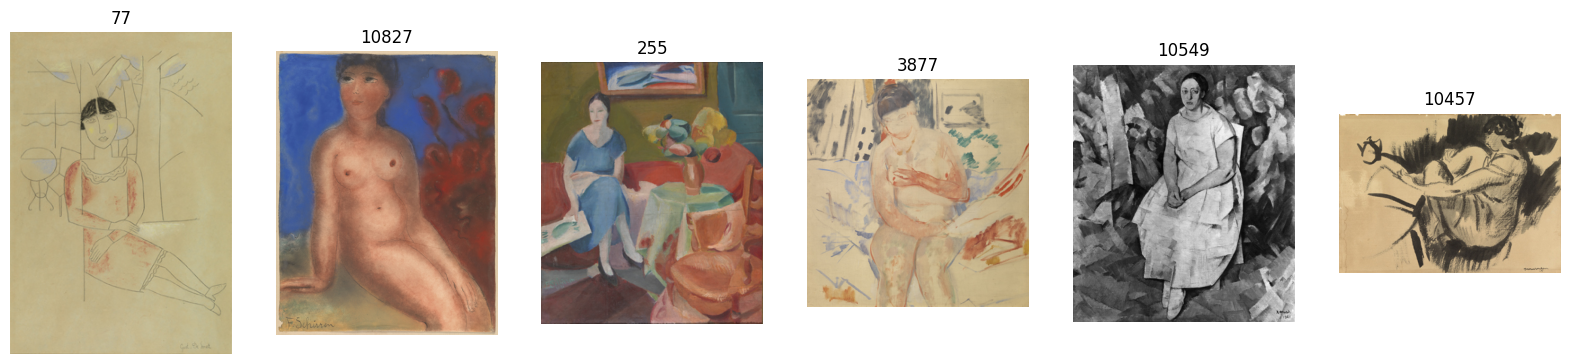

In [114]:
def get_index_of_neighbours(recordID, n=5):
    index = recordID_to_index[recordID]
    distances = cosine_distance_matrix[index]
    indices = np.argsort(distances)[1:n+1]  # Exclude the first one (itself)
    return indices

# Plot the neighbours
example_recordID = ARTWORKS["recordID"].iloc[1]
indices = get_index_of_neighbours(example_recordID, n=5)
fig, axes = plt.subplots(1, 6, figsize=(20, 5))
for i, index in enumerate([-1] + list(indices)):
    if index == -1:
        recordID = example_recordID
    else:
        recordID = index_to_recordID[str(index)]
    path = recordID_to_imageLowResFilename[recordID]
    image = Image.open(path)
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(recordID)
    axes[i].axis("off")

terms = terms_df[terms_df["recordID"] == example_recordID]["terms"].values[0]
terms = list(terms)
print(f"Terms: {terms}")

plt.show()

In [147]:
def predict_terms_using_neighbours(recordID, k=50, pk=5):
    # Get the index of the recordID
    index = recordID_to_index[recordID]

    # Get the k nearest neighbours (excluding itself)
    neighboursIndexes = get_index_of_neighbours(recordID, n=k)

    uniqueTerms = set()
    for neighbourIndex in neighboursIndexes:
        neighbourRecordID = index_to_recordID[str(neighbourIndex)]
        neighbourTerms = terms_per_recordID[neighbourRecordID]
        uniqueTerms.update(neighbourTerms)

    all_terms = {}
    for neighbourIndex in neighboursIndexes:
        distance = cosine_distance_matrix[index][neighbourIndex]
        neighbourRecordID = index_to_recordID[str(neighbourIndex)]
        neighbourTerms = terms_per_recordID[neighbourRecordID]
        for term in uniqueTerms:
            if term not in all_terms:
                all_terms[term] = 0

            if term in neighbourTerms:
                # If the term is in the neighbour's terms, add the distance
                all_terms[term] += distance
            else:
                all_terms[term] += 1.0 # If the term is not in the neighbour's terms, add 1.0 (maximum distance)
        
    # Sort the terms by their score from low to high
    sorted_terms = sorted(all_terms.items(), key=lambda x: x[1], reverse=True)

    kept_terms = []
    termIndex = 0
    scores = set()
    while len(scores) < pk:
        if termIndex >= len(sorted_terms):
            break

        term, score = sorted_terms[termIndex]
        kept_terms.append((term, score))
        scores.add(score)

        termIndex += 1

    return kept_terms

def predict_and_plot(recordID, k=50, pk=5):
    # Get the terms
    terms = predict_terms_using_neighbours(recordID, k, pk)

    # Get the recordID
    index = recordID_to_index[recordID]
    recordID = index_to_recordID[str(index)]

    # Get the image path
    image_path = recordID_to_imageLowResFilename[recordID]

    # Plot the image
    plt.imshow(Image.open(image_path), cmap="gray")
    plt.axis('off')
    plt.title(recordID)
    plt.show()

    # Print the terms
    print(f"Predicted terms for {recordID}:")
    terms = [term for term, score in terms]
    print(", ".join(terms))


In [163]:
# For each recordID in the DataFrame, predict with k=100 and pk=5 and compare with the original terms
metrics = pd.DataFrame(columns=["recordID", "has_truth", "pk", "k", "jaccard"])
for recordID in tqdm(ARTWORKS["recordID"]):
    for k in [10]:
        originalTerms = terms_df[terms_df["recordID"] == recordID]["terms"].values
        if len(originalTerms) == 0:
            originalTerms = set()
            has_truth = False
        else:
            originalTerms = originalTerms[0]
            has_truth = True
        
        for pk in [500]:
            pTerms = predict_terms_using_neighbours(recordID, k=k, pk=pk)
            pTerms = set([term for term, score in pTerms])

            originalTerms = set(originalTerms)
            intersection = originalTerms.intersection(pTerms)
            union = originalTerms.union(pTerms)
            if len(union) == 0:
                jaccard = 0
            else:
                jaccard = len(intersection) / len(union)

            metrics.loc[len(metrics)] = [recordID, has_truth, pk, k, jaccard]
        
metrics

100%|██████████| 5301/5301 [00:05<00:00, 940.99it/s] 


,recordID,has_truth,pk,k,jaccard
0,64,True,500,10,0.337500
1,77,True,500,10,0.153846
2,78,True,500,10,0.235294
3,79,True,500,10,0.215686
4,80,True,500,10,0.058824
...,...,...,...,...,...
5296,13322,False,500,10,0.000000
5297,13323,False,500,10,0.000000
5298,13377,False,500,10,0.000000
5299,13379,False,500,10,0.000000


      recordID  has_truth   pk   k  jaccard
4501     10478       True  500  10      1.0


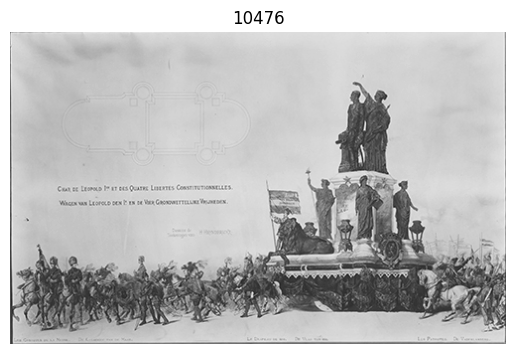

Predicted terms for 10476:
Marie-Josèphe-Rose de Tascher de La Pagerie, de profil, voûte, comte d'Egmont, honneur, Lamoral, comte de Hornes, Charles Quint, dais, Marie de Hongrie, abdication, Isabelle Claire Eugénie


In [164]:
# Get the row with the maximum jaccard
max_jaccard = metrics[metrics["has_truth"] == True].sort_values(by=["jaccard"], ascending=False).head(1)
print(max_jaccard)
predict_and_plot(max_jaccard["recordID"].values[0], k=100, pk=5)

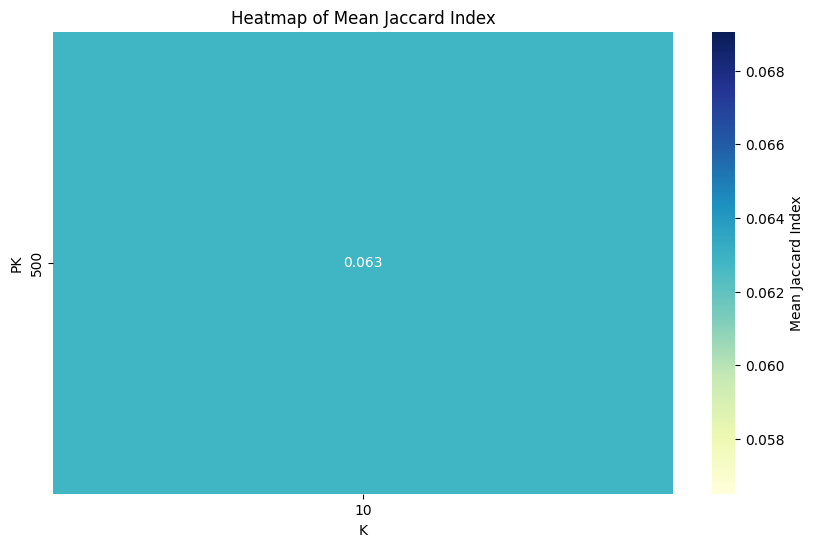

In [165]:
# Heatmap of the jaccard 
import seaborn as sns

# Create a pivot table
jaccard_pivot = metrics.pivot_table(values="jaccard", index="pk", columns="k", aggfunc="mean")

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(jaccard_pivot, annot=True, cmap="YlGnBu", cbar_kws={"label": "Mean Jaccard Index"})
plt.title("Heatmap of Mean Jaccard Index")
plt.xlabel("K")
plt.ylabel("PK")
plt.show()

In [ ]:
# USE THIS ITERATIVELY !!!

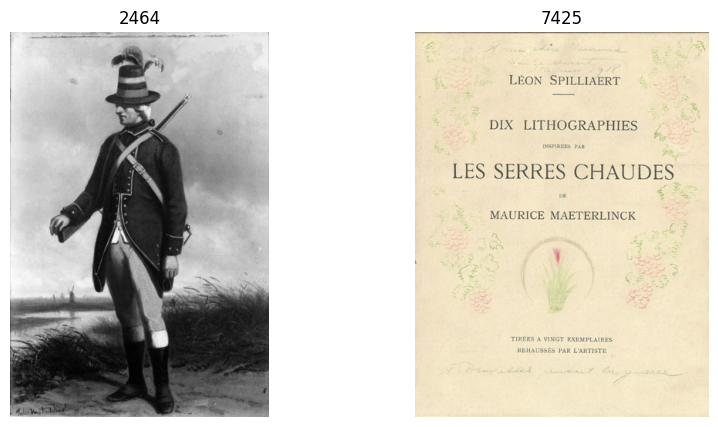

In [49]:
# Get the two image that are least similar
least_similar_indices = np.unravel_index(np.argmax(cosine_distance_matrix), cosine_distance_matrix.shape)
recordID_1 = index_to_recordID[least_similar_indices[0]]
recordID_2 = index_to_recordID[least_similar_indices[1]]

image_1 = recordID_to_imageLowResFilename[recordID_1]
image_2 = recordID_to_imageLowResFilename[recordID_2]

# Plot the two images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_1), cmap='gray')
plt.title(recordID_1)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Image.open(image_2), cmap='gray')
plt.title(recordID_2)
plt.axis('off')
plt.show()